# DIRECT FEEDBACK ALIGNMENT ON MNIST

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
# from keras.datasets import mnist
from keras.datasets import cifar10
# from keras.utils.np_utils import to_categorical
from tensorflow.python.keras.utils.np_utils import to_categorical
np.random.seed(1234) # fix first random number
%matplotlib inline

## CREATING DATASET

In [ ]:
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

X_train /= 255 # normalize data
X_test /= 255 # normalize data

170498071/170498071 [==============================] - 3s 0us/step


In [ ]:
print('Input dimensions')
print(X_train.shape, X_test.shape)
print(y_train.shape, y_test.shape)

X_train = X_train.reshape(50000, 32*32*3)
X_test = X_test.reshape(10000, 32*32*3)

print('After reshaping:', X_train.shape, X_test.shape)

Input dimensions
(50000, 32, 32, 3) (10000, 32, 32, 3)
(50000, 1) (10000, 1)
After reshaping: (50000, 3072) (10000, 3072)


In [ ]:
print('Sample of label:', y_train[0])

Sample of label: [6]


In [ ]:
nb_classes = 10
y_train = to_categorical(y_train, nb_classes)
y_test = to_categorical(y_test, nb_classes)

In [ ]:
print('After conversion to categorical:', y_train[0])

After conversion to categorical: [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]


## DEFINITION OF FORWARD AND BACKWARD PASS

In [ ]:
# import of sigmoid and crossentropy
from scipy.special import expit
from sklearn.metrics import log_loss

In [ ]:
def forward_pass(W1, W2, b1, b2, x):
    a1 = np.matmul(W1, x)+np.tile(b1, x.shape[1])
    h1 = np.tanh(a1)
    a2 = np.matmul(W2, h1)+np.tile(b2, x.shape[1])
    y_hat = expit(a2)
    return a1, h1, a2, y_hat

In [ ]:
def backprop_backward_pass(e, h1, W2, a1, x):
    dW2 = -np.matmul(e, np.transpose(h1))
    da1 = np.matmul(np.transpose(W2), e)*(1-np.tanh(a1)**2)
    dW1 = -np.matmul(da1, np.transpose(x))
    db1 = -np.sum(da1, axis=1)
    db2 = -np.sum(e, axis=1)
    return dW1, dW2, db1[:,np.newaxis], db2[:,np.newaxis]

In [ ]:
def dfa_backward_pass(e, h1, B1, a1, x):
    dW2 = -np.matmul(e, np.transpose(h1))
    da1 = np.matmul(B1, e)*(1-np.tanh(a1)**2)
    dW1 = -np.matmul(da1, np.transpose(x))
    db1 = -np.sum(da1, axis=1)
    db2 = -np.sum(e, axis=1)
    return dW1, dW2, db1[:,np.newaxis], db2[:,np.newaxis]

## DEFINITION OF FUNCTION TO COMPUTE ANGLE BETWEEN UPDATES

In [ ]:
def average_angle(W2, B1, error, a1, a2):
    dh1 = np.mean(np.matmul(B1, error), axis=1)[:, np.newaxis] #forse non ci va la derivata
    c1 = np.mean(np.matmul(np.transpose(W2), error*(expit(a2)*(1-expit(a2)))), axis=1)[:, np.newaxis]
    dh1_norm = np.linalg.norm(dh1)
    c1_norm = np.linalg.norm(c1)
    inverse_dh1_norm = np.power(dh1_norm, -1)
    inverse_c1_norm = np.power(c1_norm, -1)

    # ALIGNMENT CRITERION AND ANGLE
    Lk = (np.matmul(np.transpose(dh1), c1)*inverse_dh1_norm)[0, 0]
    beta = np.arccos(np.clip(Lk*inverse_c1_norm, -1., 1.))*180/np.pi
    return Lk, beta

In [ ]:
def train(x, y, n_epochs=10, lr=1e-3, batch_size=200, tol=1e-1):
    x = np.transpose(x)
    y = np.transpose(y)

    W1, W2 = np.random.randn(800, 784), np.random.randn(10, 800)
    b1, b2 = np.random.randn(800, 1), np.random.randn(10, 1)

    dataset_size = x.shape[1]
    n_batches = dataset_size//batch_size
    te_bp = []
    for i in range(n_epochs):
        perm = np.random.permutation(x.shape[1])
        x = x[:, perm]
        y = y[:, perm]
        loss = 0.
        train_error = 0.
        for j in range(n_batches):
            samples = x[:, j*batch_size:(j+1)*batch_size]
            targets = y[:, j*batch_size:(j+1)*batch_size]
            a1, h1, a2, y_hat = forward_pass(W1, W2, b1, b2, samples)
            error = y_hat - targets
            preds = np.argmax(y_hat, axis=0)
            truth = np.argmax(targets, axis=0)
            train_error += np.sum(preds!=truth)
            loss_on_batch = log_loss(targets, y_hat)

            dW1, dW2, db1, db2 = backprop_backward_pass(error, h1, W2, a1, samples)
            W1 += lr*dW1
            W2 += lr*dW2
            b1 += lr*db1
            b2 += lr*db2
            loss += loss_on_batch
        training_error = 1.*train_error/x.shape[1]
        print('Loss at epoch', i+1, ':', loss/x.shape[1])
        print('Training error:', training_error)
        prev_training_error = 0 if i==0 else te_bp[-1]
        # if np.abs(training_error-prev_training_error) <= tol:
        #     te_bp.append(training_error)
        #     break
        te_bp.append(training_error)
    return W1, W2, b1, b2, te_bp

In [ ]:
# print(X_train)
W1, W2, b1, b2, te_bp = train(X_train, y_train, n_epochs=100, lr=1e-4, batch_size=200, tol=1e-4)

Loss at epoch 1 : 1.1165321199224418
Training error: 0.5848333333333333
Loss at epoch 2 : 0.7147101048018146
Training error: 0.33813333333333334
Loss at epoch 3 : 0.6159950462743812
Training error: 0.26448333333333335
Loss at epoch 4 : 0.5675356330154221
Training error: 0.22795
Loss at epoch 5 : 0.5370808438177351
Training error: 0.20353333333333334
Loss at epoch 6 : 0.5152797502538295
Training error: 0.18718333333333334
Loss at epoch 7 : 0.4988478810093226
Training error: 0.17538333333333334
Loss at epoch 8 : 0.48565413749281844
Training error: 0.16531666666666667
Loss at epoch 9 : 0.47495979580336256
Training error: 0.15676666666666667
Loss at epoch 10 : 0.46568583994101553
Training error: 0.14978333333333332
Loss at epoch 11 : 0.45776661436154953
Training error: 0.1435
Loss at epoch 12 : 0.4506846597742356
Training error: 0.13766666666666666
Loss at epoch 13 : 0.44451743884338424
Training error: 0.13308333333333333
Loss at epoch 14 : 0.43868453352062753
Training error: 0.1285
Loss a

In [ ]:
def dfa_train(x, y, n_epochs=10, lr=1e-3, batch_size=200, tol=1e-3):
    x = np.transpose(x)
    y = np.transpose(y)

    W1, W2 = np.random.randn(800, 784), np.random.randn(10, 800)
    b1, b2 = np.random.randn(800, 1), np.random.randn(10, 1)

    B1 = np.random.randn(800, 10)
    dataset_size = x.shape[1]
    n_batches = dataset_size//batch_size
    te_dfa = []
    angles = []
    for i in range(n_epochs):
        perm = np.random.permutation(x.shape[1])
        x = x[:, perm]
        y = y[:, perm]
        loss = 0.
        train_error = 0.
        for j in range(n_batches):
            samples = x[:, j*batch_size:(j+1)*batch_size]
            targets = y[:, j*batch_size:(j+1)*batch_size]
            a1, h1, a2, y_hat = forward_pass(W1, W2, b1, b2, samples)
            error = y_hat - targets
            preds = np.argmax(y_hat, axis=0)
            truth = np.argmax(targets, axis=0)
            train_error += 1.*np.sum(preds!=truth)
            loss_on_batch = log_loss(targets, y_hat)

            dW1, dW2, db1, db2 = dfa_backward_pass(error, h1, B1, a1, samples)
            W1 += lr*dW1
            W2 += lr*dW2
            b1 += lr*db1
            b2 += lr*db2
            loss += loss_on_batch
            if j%100==0:
                angles.append(average_angle(W2, B1, error, a1, a2))
        training_error = 1.*train_error/x.shape[1]
        # print('Loss at epoch', i+1, ':', loss/x.shape[1])
        print('Epoch', i+1, ':')
        print('Training error:', training_error)
        prev_training_error = 0 if i==0 else te_dfa[-1]
        # if np.abs(training_error-prev_training_error) <= tol:
        #     te_dfa.append(training_error)
        #     break
        te_dfa.append(training_error)
    return W1, W2, b1, b2, te_dfa, angles

In [ ]:
W1dfa, W2dfa, b1dfa, b2dfa, te_dfa, angles = dfa_train(X_train, y_train, n_epochs=100, lr=1e-4, batch_size=200, tol=1e-4)

Epoch 1 :
Training error: 0.7366833333333334
Epoch 2 :
Training error: 0.4908
Epoch 3 :
Training error: 0.3854666666666667
Epoch 4 :
Training error: 0.32903333333333334
Epoch 5 :
Training error: 0.2898
Epoch 6 :
Training error: 0.26285
Epoch 7 :
Training error: 0.24266666666666667
Epoch 8 :
Training error: 0.22778333333333334
Epoch 9 :
Training error: 0.21485
Epoch 10 :
Training error: 0.20451666666666668
Epoch 11 :
Training error: 0.19528333333333334
Epoch 12 :
Training error: 0.18718333333333334
Epoch 13 :
Training error: 0.18058333333333335
Epoch 14 :
Training error: 0.17423333333333332
Epoch 15 :
Training error: 0.16851666666666668
Epoch 16 :
Training error: 0.16361666666666666
Epoch 17 :
Training error: 0.15928333333333333
Epoch 18 :
Training error: 0.15483333333333332
Epoch 19 :
Training error: 0.15166666666666667
Epoch 20 :
Training error: 0.14758333333333334
Epoch 21 :
Training error: 0.14453333333333335
Epoch 22 :
Training error: 0.14146666666666666
Epoch 23 :
Training error: 

In [ ]:
def test(W1, W2, b1, b2, test_samples, test_targets):
    test_samples = np.transpose(test_samples)
    test_targets = np.transpose(test_targets)
    outs = forward_pass(W1, W2, b1, b2, test_samples)[-1]
    preds = np.argmax(outs, axis=0)
    truth = np.argmax(test_targets, axis=0)
    test_error = 1.*np.sum(preds!=truth)/preds.shape[0]
    return test_error

In [ ]:
print('BP:', test(W1, W2, b1, b2, X_test, y_test)*100, '%')
print('DFA:', test(W1dfa, W2dfa, b1dfa, b2dfa, X_test, y_test)*100, '%')

BP: 8.12 %
DFA: 7.76 %


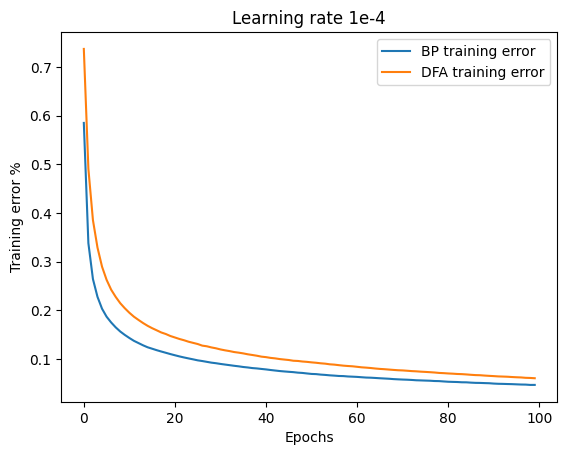

In [ ]:
plt.plot(range(len(te_bp)), te_bp, label='BP training error')
plt.plot(range(len(te_dfa)), te_dfa, label='DFA training error')
plt.title('Learning rate 1e-4')
plt.xlabel('Epochs')
plt.ylabel('Training error %')
plt.legend(loc='best')
plt.savefig("output_1.jpg")
plt.show()

In [ ]:
l, beta = zip(*angles)

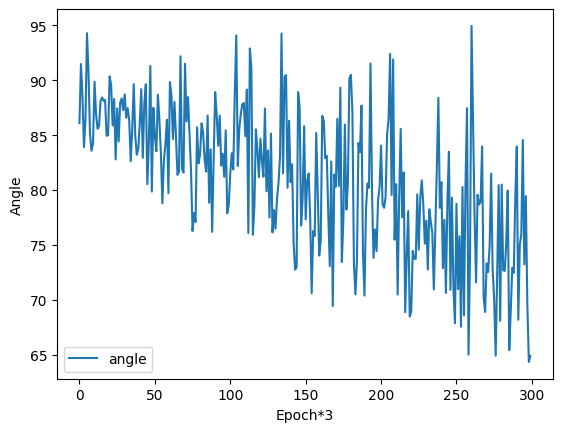

In [ ]:
plt.plot(range(len(beta)), beta, label='angle')
plt.legend(loc='best')
plt.xlabel('Epoch*3')
plt.ylabel('Angle')
plt.savefig("output_2.jpg")
plt.show()